1. LargeKernel
2. IsometricConv
3. SmallKernel
4. MedianKernel
5. MultiScaleKernel(Parallel)
6. MultiScaleKernel(Series-Larger)
7. MultiScaleKernel(Series-Smaller)
8. MultiScaleKernel(Series-Ridge)
9. MultiScaleKernel(Series-Valley)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from einops import rearrange

In [2]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [3]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n

device = torch.device("cuda")
lr = 0.0001
epochs=300
loss=nn.CrossEntropyLoss()
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=1,S=1):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

1.LargeKernel

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


epoch1,loss0.0019,train acc 0.810804,val acc 0.860
epoch2,loss0.0017,train acc 0.870616,val acc 0.882
epoch3,loss0.0016,train acc 0.888349,val acc 0.889
epoch4,loss0.0016,train acc 0.899106,val acc 0.901
epoch5,loss0.0016,train acc 0.908269,val acc 0.917
epoch6,loss0.0015,train acc 0.914591,val acc 0.919
epoch7,loss0.0015,train acc 0.921787,val acc 0.931
epoch8,loss0.0015,train acc 0.925172,val acc 0.925
epoch9,loss0.0015,train acc 0.930914,val acc 0.930
epoch10,loss0.0015,train acc 0.931846,val acc 0.934
epoch11,loss0.0015,train acc 0.935444,val acc 0.938
epoch12,loss0.0015,train acc 0.937316,val acc 0.942
epoch13,loss0.0015,train acc 0.941083,val acc 0.933
epoch14,loss0.0014,train acc 0.941920,val acc 0.944
epoch15,loss0.0014,train acc 0.945070,val acc 0.945
epoch16,loss0.0014,train acc 0.945782,val acc 0.939
epoch17,loss0.0014,train acc 0.946708,val acc 0.942
epoch18,loss0.0014,train acc 0.947677,val acc 0.944
epoch19,loss0.0014,train acc 0.948007,val acc 0.938
epoch20,loss0.0014,tr

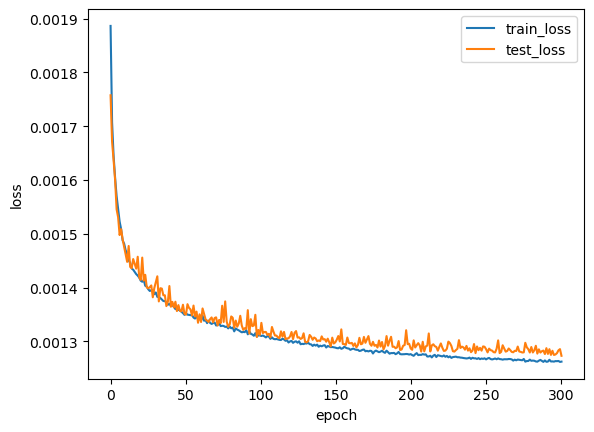

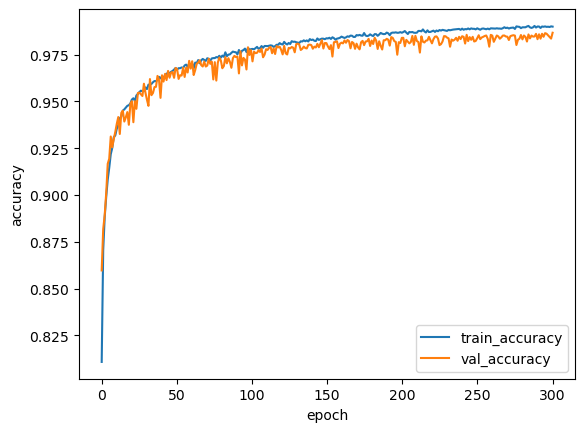

Accuracy on test set : 0.987
test precision: 0.9875268824433716  test recall: 0.9803858526860774  test f1_score: 0.9838590906686923


In [4]:
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_ks1_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_ks1_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

2.IsometricConv

epoch1,loss0.0019,train acc 0.811244,val acc 0.838
epoch2,loss0.0017,train acc 0.858846,val acc 0.877
epoch3,loss0.0017,train acc 0.874302,val acc 0.880
epoch4,loss0.0017,train acc 0.882600,val acc 0.880
epoch5,loss0.0016,train acc 0.888804,val acc 0.898
epoch6,loss0.0016,train acc 0.892754,val acc 0.898
epoch7,loss0.0016,train acc 0.900839,val acc 0.911
epoch8,loss0.0016,train acc 0.902571,val acc 0.893
epoch9,loss0.0016,train acc 0.911830,val acc 0.917
epoch10,loss0.0015,train acc 0.916654,val acc 0.919
epoch11,loss0.0015,train acc 0.920759,val acc 0.924
epoch12,loss0.0015,train acc 0.924181,val acc 0.909
epoch13,loss0.0015,train acc 0.927191,val acc 0.913
epoch14,loss0.0015,train acc 0.929049,val acc 0.928
epoch15,loss0.0015,train acc 0.931420,val acc 0.908
epoch16,loss0.0015,train acc 0.934401,val acc 0.933
epoch17,loss0.0015,train acc 0.932500,val acc 0.938
epoch18,loss0.0015,train acc 0.935422,val acc 0.937
epoch19,loss0.0015,train acc 0.939835,val acc 0.944
epoch20,loss0.0015,tr

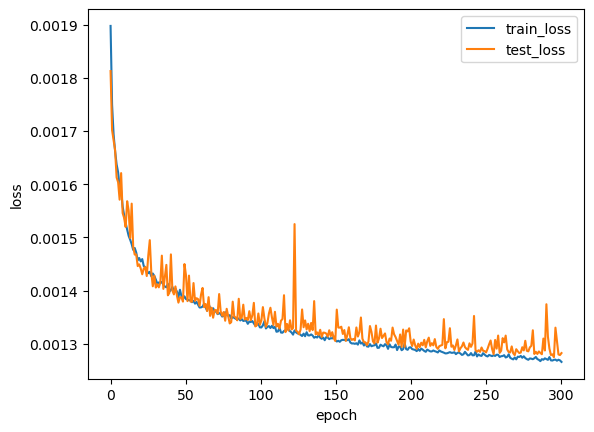

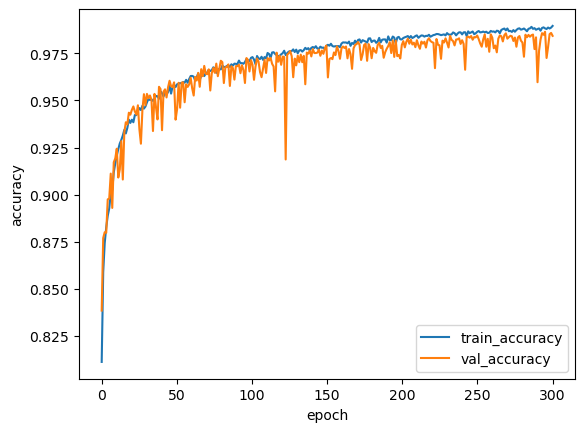

Accuracy on test set : 0.987
test precision: 0.9848011084192377  test recall: 0.9844705502116564  test f1_score: 0.9845615317930646


In [6]:
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding=0,stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv_s(x)
        return out    

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.isometric_conv(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_ks2_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_ks2_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

3.SmallKernel

epoch1,loss0.0019,train acc 0.799746,val acc 0.823
epoch2,loss0.0018,train acc 0.840497,val acc 0.858
epoch3,loss0.0017,train acc 0.859595,val acc 0.860
epoch4,loss0.0017,train acc 0.870308,val acc 0.875
epoch5,loss0.0017,train acc 0.873752,val acc 0.863
epoch6,loss0.0017,train acc 0.878025,val acc 0.883
epoch7,loss0.0017,train acc 0.881542,val acc 0.885
epoch8,loss0.0017,train acc 0.884920,val acc 0.873
epoch9,loss0.0017,train acc 0.886704,val acc 0.885
epoch10,loss0.0016,train acc 0.888576,val acc 0.884
epoch11,loss0.0016,train acc 0.890889,val acc 0.888
epoch12,loss0.0016,train acc 0.892975,val acc 0.885
epoch13,loss0.0016,train acc 0.895053,val acc 0.899
epoch14,loss0.0016,train acc 0.898048,val acc 0.901
epoch15,loss0.0016,train acc 0.898871,val acc 0.899
epoch16,loss0.0016,train acc 0.901198,val acc 0.907
epoch17,loss0.0016,train acc 0.905795,val acc 0.905
epoch18,loss0.0016,train acc 0.906177,val acc 0.910
epoch19,loss0.0016,train acc 0.909525,val acc 0.905
epoch20,loss0.0016,tr

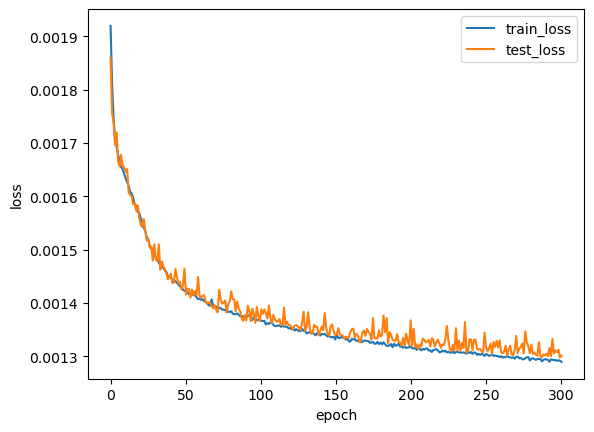

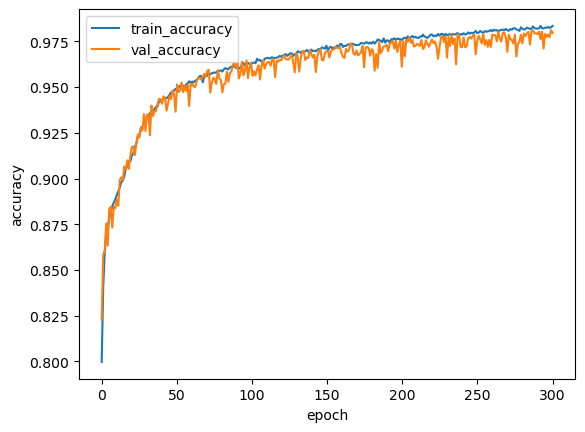

Accuracy on test set : 0.982
test precision: 0.9765526051861424  test recall: 0.9809754526432088  test f1_score: 0.9786446592105608


In [7]:
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim),
        )


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_ks3_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_ks3_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

4.MedianKernel

epoch1,loss0.0019,train acc 0.793013,val acc 0.811
epoch2,loss0.0018,train acc 0.829080,val acc 0.847
epoch3,loss0.0017,train acc 0.859243,val acc 0.874
epoch4,loss0.0017,train acc 0.873568,val acc 0.871
epoch5,loss0.0017,train acc 0.882923,val acc 0.886
epoch6,loss0.0016,train acc 0.888158,val acc 0.896
epoch7,loss0.0016,train acc 0.894399,val acc 0.898
epoch8,loss0.0016,train acc 0.899399,val acc 0.905
epoch9,loss0.0016,train acc 0.904363,val acc 0.910
epoch10,loss0.0016,train acc 0.909752,val acc 0.886
epoch11,loss0.0016,train acc 0.912499,val acc 0.917
epoch12,loss0.0015,train acc 0.917381,val acc 0.922
epoch13,loss0.0015,train acc 0.920304,val acc 0.920
epoch14,loss0.0015,train acc 0.923351,val acc 0.925
epoch15,loss0.0015,train acc 0.926978,val acc 0.927
epoch16,loss0.0015,train acc 0.929533,val acc 0.922
epoch17,loss0.0015,train acc 0.930268,val acc 0.930
epoch18,loss0.0015,train acc 0.932874,val acc 0.933
epoch19,loss0.0015,train acc 0.934188,val acc 0.933
epoch20,loss0.0015,tr

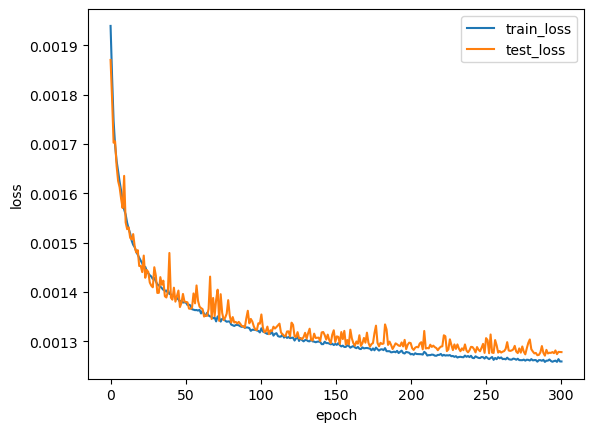

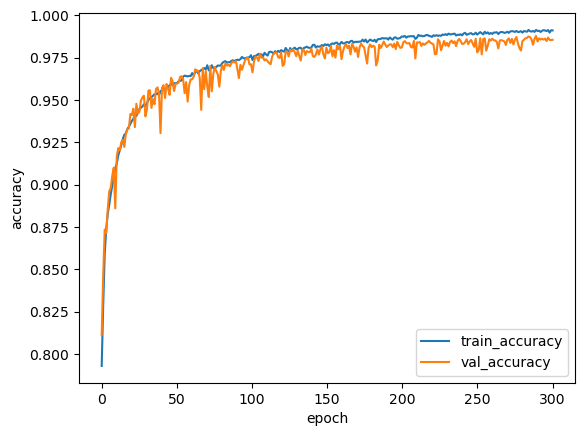

Accuracy on test set : 0.988
test precision: 0.9881613326677838  test recall: 0.9822272802816161  test f1_score: 0.985108011481266


In [8]:
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        )


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_ks4_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_ks4_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

5.MultiScaleKernel(Parallel)

epoch1,loss0.0020,train acc 0.760280,val acc 0.766
epoch2,loss0.0019,train acc 0.813513,val acc 0.835
epoch3,loss0.0018,train acc 0.846423,val acc 0.864
epoch4,loss0.0017,train acc 0.866791,val acc 0.880
epoch5,loss0.0017,train acc 0.877063,val acc 0.883
epoch6,loss0.0017,train acc 0.884670,val acc 0.894
epoch7,loss0.0016,train acc 0.892703,val acc 0.902
epoch8,loss0.0016,train acc 0.898004,val acc 0.906
epoch9,loss0.0016,train acc 0.904679,val acc 0.913
epoch10,loss0.0016,train acc 0.909510,val acc 0.914
epoch11,loss0.0015,train acc 0.916067,val acc 0.902
epoch12,loss0.0015,train acc 0.919724,val acc 0.923
epoch13,loss0.0015,train acc 0.920406,val acc 0.925
epoch14,loss0.0015,train acc 0.925253,val acc 0.927
epoch15,loss0.0015,train acc 0.927514,val acc 0.928
epoch16,loss0.0015,train acc 0.929225,val acc 0.929
epoch17,loss0.0015,train acc 0.929820,val acc 0.931
epoch18,loss0.0015,train acc 0.931097,val acc 0.929
epoch19,loss0.0015,train acc 0.931956,val acc 0.930
epoch20,loss0.0015,tr

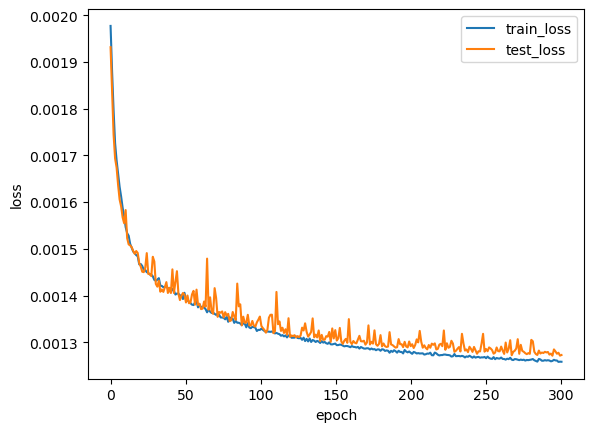

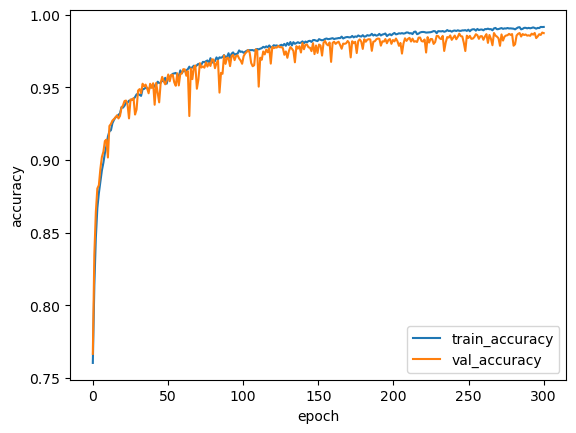

Accuracy on test set : 0.987
test precision: 0.9847032900245264  test recall: 0.9851262740092447  test f1_score: 0.9848455868036019


In [9]:
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_b1 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b2 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b3 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b4 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]
        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y1 = self.conv_b1(x)
        y2 = self.conv_b2(x)
        y3 = self.conv_b3(x)
        y4 = self.conv_b4(x)
        y = y1 + y2 +y3 + y4 + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_ks5_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_ks5_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

6.MultiScaleKernel(Series-Larger)

epoch1,loss0.0019,train acc 0.790245,val acc 0.807
epoch2,loss0.0019,train acc 0.822302,val acc 0.846
epoch3,loss0.0018,train acc 0.855579,val acc 0.870
epoch4,loss0.0017,train acc 0.869038,val acc 0.866
epoch5,loss0.0017,train acc 0.875066,val acc 0.876
epoch6,loss0.0017,train acc 0.880140,val acc 0.888
epoch7,loss0.0017,train acc 0.882306,val acc 0.882
epoch8,loss0.0016,train acc 0.887291,val acc 0.887
epoch9,loss0.0016,train acc 0.889142,val acc 0.885
epoch10,loss0.0016,train acc 0.890970,val acc 0.885
epoch11,loss0.0016,train acc 0.895258,val acc 0.897
epoch12,loss0.0016,train acc 0.896550,val acc 0.902
epoch13,loss0.0016,train acc 0.899715,val acc 0.896
epoch14,loss0.0016,train acc 0.901602,val acc 0.905
epoch15,loss0.0016,train acc 0.903085,val acc 0.898
epoch16,loss0.0016,train acc 0.905354,val acc 0.910
epoch17,loss0.0016,train acc 0.906727,val acc 0.908
epoch18,loss0.0016,train acc 0.909114,val acc 0.913
epoch19,loss0.0016,train acc 0.912954,val acc 0.907
epoch20,loss0.0016,tr

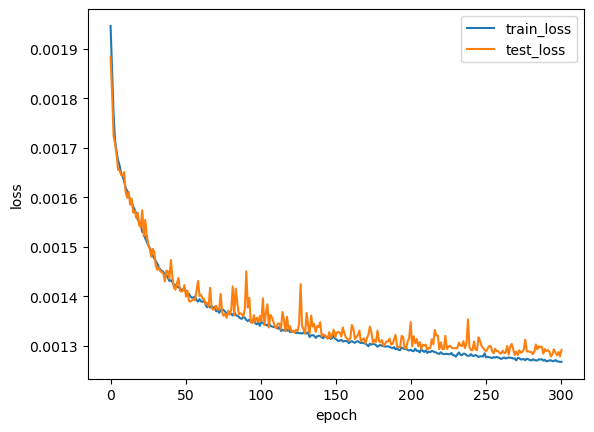

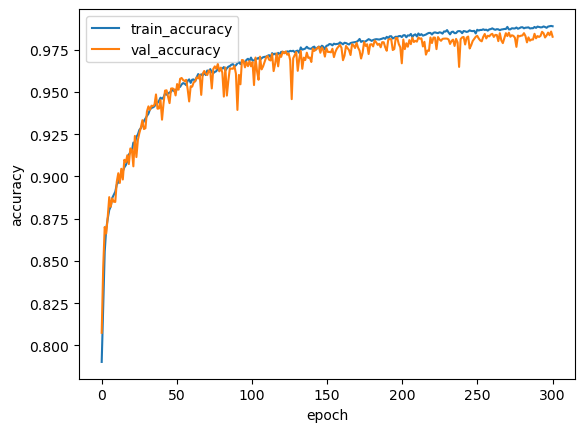

Accuracy on test set : 0.986
test precision: 0.9850878198293659  test recall: 0.9824742392055805  test f1_score: 0.9836966797614154


In [10]:
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim),
        )


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_ks6_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_ks6_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

7.MultiScaleKernel(Series-Smaller)

epoch1,loss0.0020,train acc 0.757761,val acc 0.762
epoch2,loss0.0019,train acc 0.761726,val acc 0.762
epoch3,loss0.0019,train acc 0.762673,val acc 0.764
epoch4,loss0.0018,train acc 0.762938,val acc 0.764
epoch5,loss0.0018,train acc 0.763092,val acc 0.763
epoch6,loss0.0018,train acc 0.763334,val acc 0.763
epoch7,loss0.0018,train acc 0.763415,val acc 0.762
epoch8,loss0.0018,train acc 0.763819,val acc 0.765
epoch9,loss0.0018,train acc 0.764685,val acc 0.764
epoch10,loss0.0018,train acc 0.764428,val acc 0.765
epoch11,loss0.0018,train acc 0.764715,val acc 0.763
epoch12,loss0.0018,train acc 0.767130,val acc 0.766
epoch13,loss0.0017,train acc 0.845336,val acc 0.872
epoch14,loss0.0017,train acc 0.881821,val acc 0.885
epoch15,loss0.0016,train acc 0.885992,val acc 0.891
epoch16,loss0.0016,train acc 0.889648,val acc 0.894
epoch17,loss0.0016,train acc 0.892218,val acc 0.894
epoch18,loss0.0016,train acc 0.895926,val acc 0.896
epoch19,loss0.0016,train acc 0.898746,val acc 0.901
epoch20,loss0.0016,tr

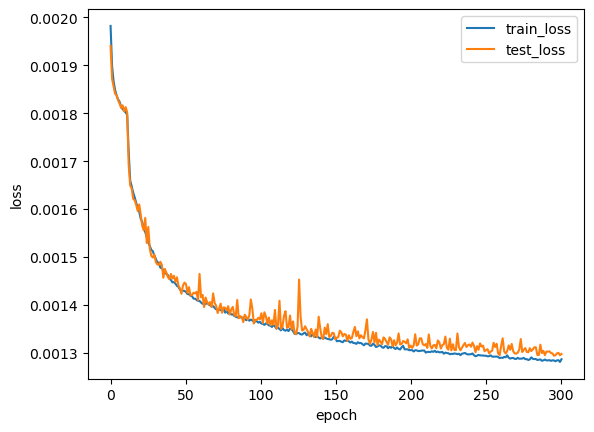

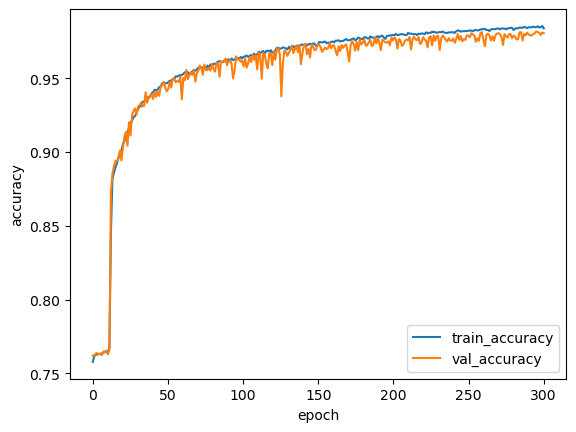

Accuracy on test set : 0.982
test precision: 0.9818825476017077  test recall: 0.9754923979567091  test f1_score: 0.9785559658668086


In [11]:
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim),
        )


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_ks7_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_ks7_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

8.MultiScaleKernel(Series-Ridge)

9.MultiScaleKernel(Series-Valley)